## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


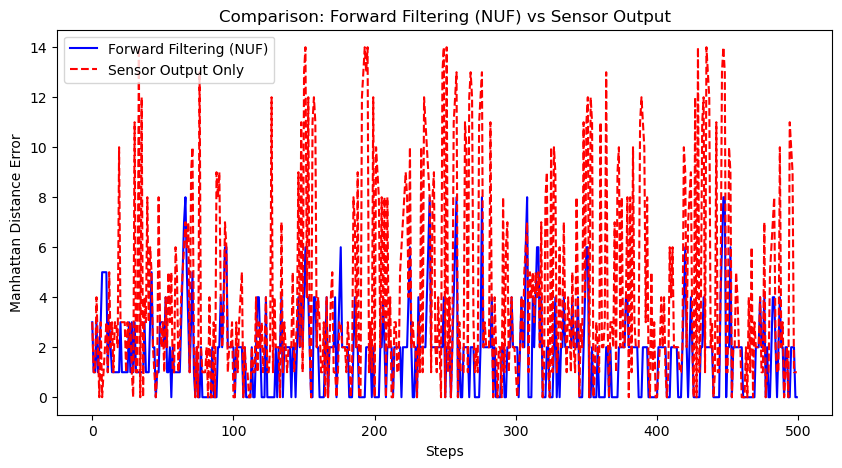

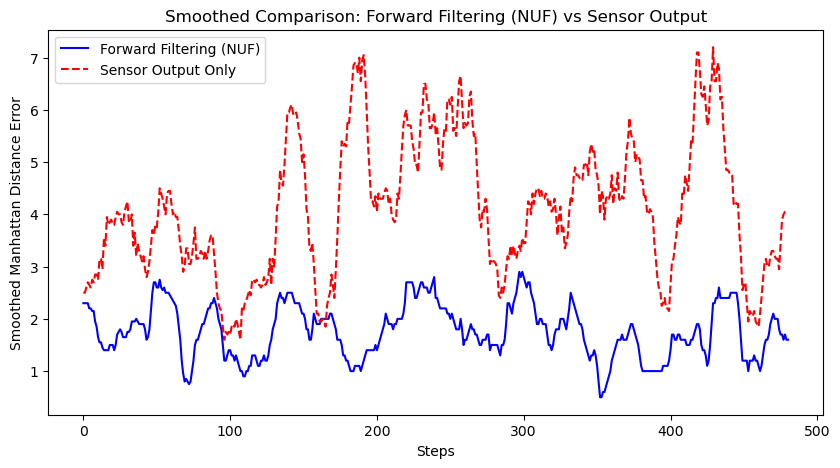

Average error (NUF Filtering): 1.77
Average error (Sensor Output Only): 4.05


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# اضافه کردن مسیر پروژه به `sys.path`
sys.path.append(os.path.abspath("."))

from models import StateModel, TransitionModel, RobotSim
from models.ObservationModel_NUF import ObservationModel
from Filters import HMMFilter

def run_experiment_nuf_vs_sensor(grid_size, steps):
    state_model = StateModel(*grid_size)
    transition_model = TransitionModel(state_model)
    observation_model = ObservationModel(state_model)

    true_state = np.random.randint(state_model.get_num_of_states())
    hmm_filter = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model, state_model)
    robot_sim = RobotSim(true_state, state_model)
    
    true_positions = []
    estimated_positions_filter = []
    estimated_positions_sensor = []
    errors_filter = []
    errors_sensor = []

    for _ in range(steps):
        true_state = robot_sim.move_once(transition_model)
        sensor_reading = robot_sim.sense_in_current_state(observation_model)
        filtered_prob = hmm_filter.filter(sensor_reading)
        
        true_pos = state_model.state_to_position(true_state)
        estimated_filter = state_model.state_to_position(np.argmax(filtered_prob))
        estimated_sensor = state_model.reading_to_position(sensor_reading) if sensor_reading is not None else (0, 0)

        true_positions.append(true_pos)
        estimated_positions_filter.append(estimated_filter)
        estimated_positions_sensor.append(estimated_sensor)

        errors_filter.append(abs(true_pos[0] - estimated_filter[0]) + abs(true_pos[1] - estimated_filter[1]))
        errors_sensor.append(abs(true_pos[0] - estimated_sensor[0]) + abs(true_pos[1] - estimated_sensor[1]))

    return np.array(errors_filter), np.array(errors_sensor)

grid_size = (8, 8)  
steps = 500  
errors_filter, errors_sensor = run_experiment_nuf_vs_sensor(grid_size, steps)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(steps), errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(steps), errors_sensor, label="Sensor Output Only", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Manhattan Distance Error")
plt.title("Comparison: Forward Filtering (NUF) vs Sensor Output")
plt.legend()
plt.show()


window_size = 20  # تعداد نقاط برای میانگین‌گیری
smoothed_errors_filter = np.convolve(errors_filter, np.ones(window_size)/window_size, mode='valid')
smoothed_errors_sensor = np.convolve(errors_sensor, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(smoothed_errors_filter)), smoothed_errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(len(smoothed_errors_sensor)), smoothed_errors_sensor, label="Sensor Output Only", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Smoothed Manhattan Distance Error")
plt.title("Smoothed Comparison: Forward Filtering (NUF) vs Sensor Output")
plt.legend()
plt.show()

print(f"Average error (NUF Filtering): {np.mean(errors_filter):.2f}")
print(f"Average error (Sensor Output Only): {np.mean(errors_sensor):.2f}")


Sensor failure rate: 0.31


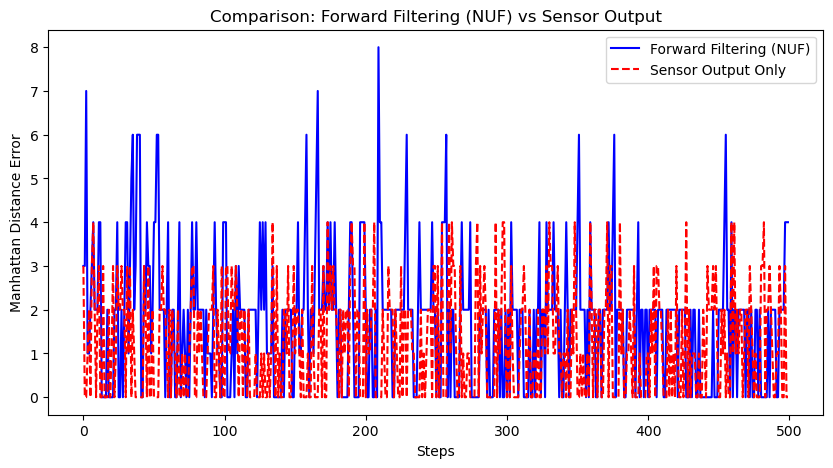

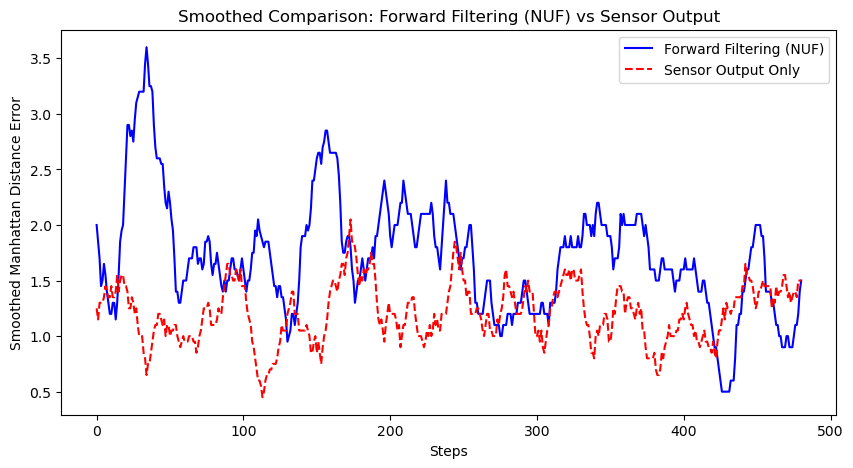

Average error (NUF Filtering): 1.75
Average error (Sensor Output Only): 1.21
Sensor failure rate: 0.31


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from models import StateModel, TransitionModel, RobotSim
from models.ObservationModel_NUF import ObservationModel as ObservationModelNUF
from models.ObservationModel_UF import ObservationModelUF
from Filters import HMMFilter

def run_experiment_nuf_vs_uf(grid_size, steps):
    state_model = StateModel(*grid_size)
    transition_model = TransitionModel(state_model)

    # مدل‌های مشاهده (Observation Models)
    observation_model_nuf = ObservationModelNUF(state_model)
    observation_model_uf = ObservationModelUF(state_model)

    # مقداردهی اولیه برای فیلترینگ
    true_state = np.random.randint(state_model.get_num_of_states())
    hmm_filter_nuf = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model_nuf, state_model)
    hmm_filter_uf = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model_uf, state_model)

    robot_sim = RobotSim(true_state, state_model)
    
    true_positions = []
    errors_nuf = []
    errors_uf = []

    for _ in range(steps):
        true_state = robot_sim.move_once(transition_model)
        sensor_reading = robot_sim.sense_in_current_state(observation_model_nuf)  # از یک سنسور مشترک استفاده کنید

        # اجرای فیلترینگ
        filtered_prob_nuf = hmm_filter_nuf.filter(sensor_reading)
        filtered_prob_uf = hmm_filter_uf.filter(sensor_reading)
        
        true_pos = state_model.state_to_position(true_state)
        estimated_nuf = state_model.state_to_position(np.argmax(filtered_prob_nuf))
        estimated_uf = state_model.state_to_position(np.argmax(filtered_prob_uf))

        true_positions.append(true_pos)

        errors_nuf.append(abs(true_pos[0] - estimated_nuf[0]) + abs(true_pos[1] - estimated_nuf[1]))
        errors_uf.append(abs(true_pos[0] - estimated_uf[0]) + abs(true_pos[1] - estimated_uf[1]))

    return np.array(errors_nuf), np.array(errors_uf)

# اجرای آزمایش برای 4×4
grid_size = (4, 4)
steps = 500
errors_nuf, errors_uf = run_experiment_nuf_vs_uf(grid_size, steps)

# محاسبه میانگین کل خطاها
avg_error_nuf = np.mean(errors_nuf)
avg_error_uf = np.mean(errors_uf)

# اعمال میانگین متحرک برای هموارسازی نمودار
window_size = 20  # تعداد نقاط برای میانگین‌گیری
smoothed_errors_nuf = np.convolve(errors_nuf, np.ones(window_size)/window_size, mode='valid')
smoothed_errors_uf = np.convolve(errors_uf, np.ones(window_size)/window_size, mode='valid')

# رسم نمودار مقایسه
plt.figure(figsize=(10, 8))

# نمودار اصلی بدون هموارسازی
plt.subplot(2, 1, 1)
plt.plot(np.arange(steps), errors_nuf, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(steps), errors_uf, label="Forward Filtering (UF)", color="green", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Manhattan Distance Error")
plt.title("Comparison: Forward Filtering (NUF) vs Forward Filtering (UF) in 4x4 Grid")
plt.legend()

# نمودار هموار شده
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(smoothed_errors_nuf)), smoothed_errors_nuf, label="Smoothed Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(len(smoothed_errors_uf)), smoothed_errors_uf, label="Smoothed Forward Filtering (UF)", color="green", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Smoothed Manhattan Distance Error")
plt.title("Smoothed Comparison: Forward Filtering (NUF) vs Forward Filtering (UF)")
plt.legend()

plt.tight_layout()
plt.show()

# نمایش میانگین کلی خطا
print(f"Average error (NUF Filtering): {avg_error_nuf:.2f}")
print(f"Average error (UF Filtering): {avg_error_uf:.2f}")


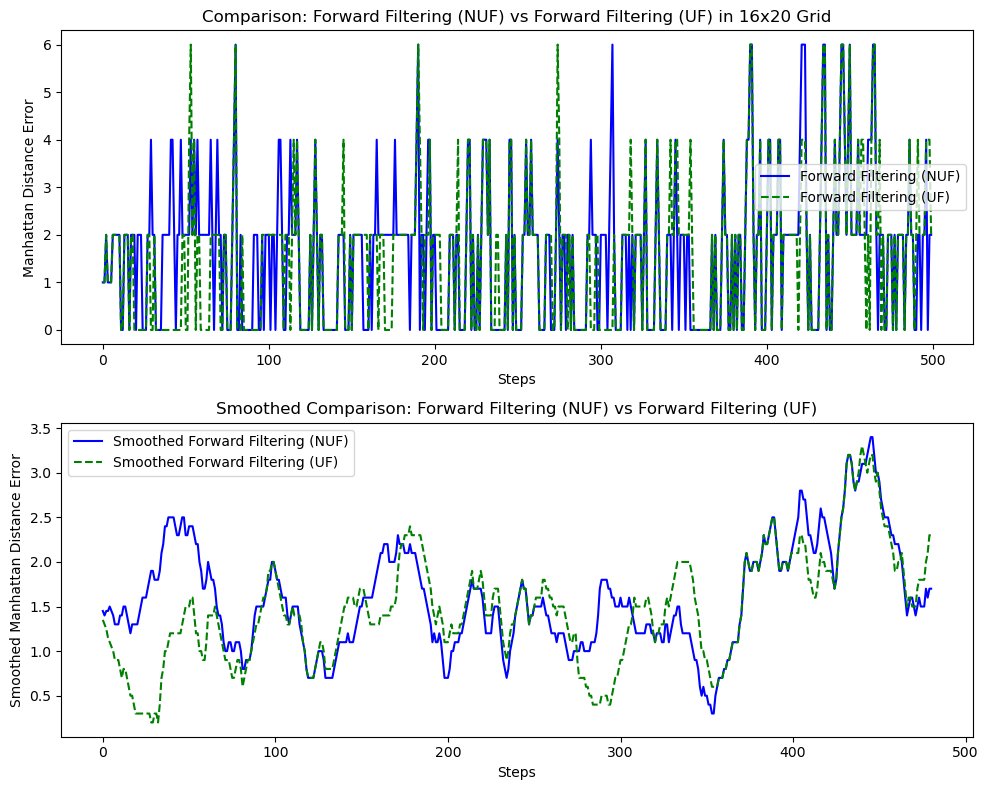

Average error (NUF Filtering): 1.60
Average error (UF Filtering): 1.49


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from models import StateModel, TransitionModel, RobotSim
from models.ObservationModel_NUF import ObservationModel as ObservationModelNUF
from models.ObservationModel_UF import ObservationModelUF
from Filters import HMMFilter

def run_experiment_nuf_vs_uf(grid_size, steps):
    state_model = StateModel(*grid_size)
    transition_model = TransitionModel(state_model)

    # مدل‌های مشاهده (Observation Models)
    observation_model_nuf = ObservationModelNUF(state_model)
    observation_model_uf = ObservationModelUF(state_model)

    # مقداردهی اولیه برای فیلترینگ
    true_state = np.random.randint(state_model.get_num_of_states())
    hmm_filter_nuf = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model_nuf, state_model)
    hmm_filter_uf = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model_uf, state_model)

    robot_sim = RobotSim(true_state, state_model)
    
    true_positions = []
    errors_nuf = []
    errors_uf = []

    for _ in range(steps):
        true_state = robot_sim.move_once(transition_model)
        sensor_reading = robot_sim.sense_in_current_state(observation_model_nuf)  # از یک سنسور مشترک استفاده کنید

        # اجرای فیلترینگ
        filtered_prob_nuf = hmm_filter_nuf.filter(sensor_reading)
        filtered_prob_uf = hmm_filter_uf.filter(sensor_reading)
        
        true_pos = state_model.state_to_position(true_state)
        estimated_nuf = state_model.state_to_position(np.argmax(filtered_prob_nuf))
        estimated_uf = state_model.state_to_position(np.argmax(filtered_prob_uf))

        true_positions.append(true_pos)

        errors_nuf.append(abs(true_pos[0] - estimated_nuf[0]) + abs(true_pos[1] - estimated_nuf[1]))
        errors_uf.append(abs(true_pos[0] - estimated_uf[0]) + abs(true_pos[1] - estimated_uf[1]))

    return np.array(errors_nuf), np.array(errors_uf)

# اجرای آزمایش برای 16×20
grid_size = (16, 20)
steps = 500
errors_nuf, errors_uf = run_experiment_nuf_vs_uf(grid_size, steps)

# محاسبه میانگین کل خطاها
avg_error_nuf = np.mean(errors_nuf)
avg_error_uf = np.mean(errors_uf)

# اعمال میانگین متحرک برای هموارسازی نمودار
window_size = 20  # تعداد نقاط برای میانگین‌گیری
smoothed_errors_nuf = np.convolve(errors_nuf, np.ones(window_size)/window_size, mode='valid')
smoothed_errors_uf = np.convolve(errors_uf, np.ones(window_size)/window_size, mode='valid')

# رسم نمودار مقایسه
plt.figure(figsize=(10, 8))

# نمودار اصلی بدون هموارسازی
plt.subplot(2, 1, 1)
plt.plot(np.arange(steps), errors_nuf, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(steps), errors_uf, label="Forward Filtering (UF)", color="green", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Manhattan Distance Error")
plt.title("Comparison: Forward Filtering (NUF) vs Forward Filtering (UF) in 16x20 Grid")
plt.legend()

# نمودار هموار شده
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(smoothed_errors_nuf)), smoothed_errors_nuf, label="Smoothed Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(len(smoothed_errors_uf)), smoothed_errors_uf, label="Smoothed Forward Filtering (UF)", color="green", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Smoothed Manhattan Distance Error")
plt.title("Smoothed Comparison: Forward Filtering (NUF) vs Forward Filtering (UF)")
plt.legend()

plt.tight_layout()
plt.show()

# نمایش میانگین کلی خطا
print(f"Average error (NUF Filtering): {avg_error_nuf:.2f}")
print(f"Average error (UF Filtering): {avg_error_uf:.2f}")


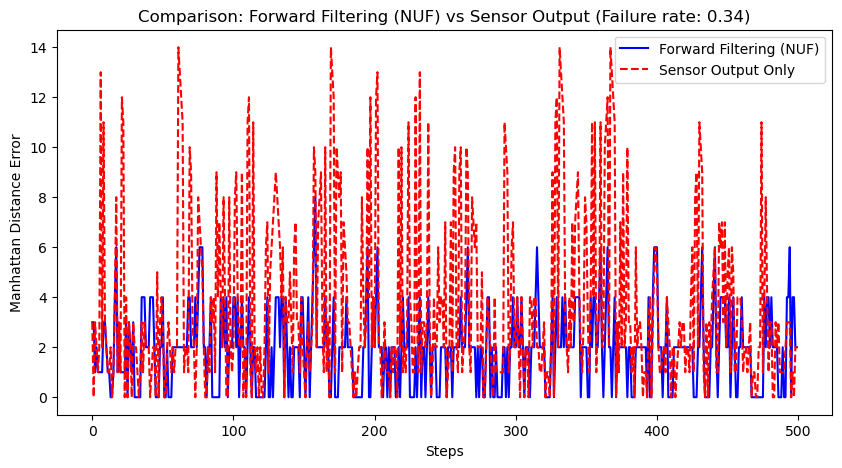

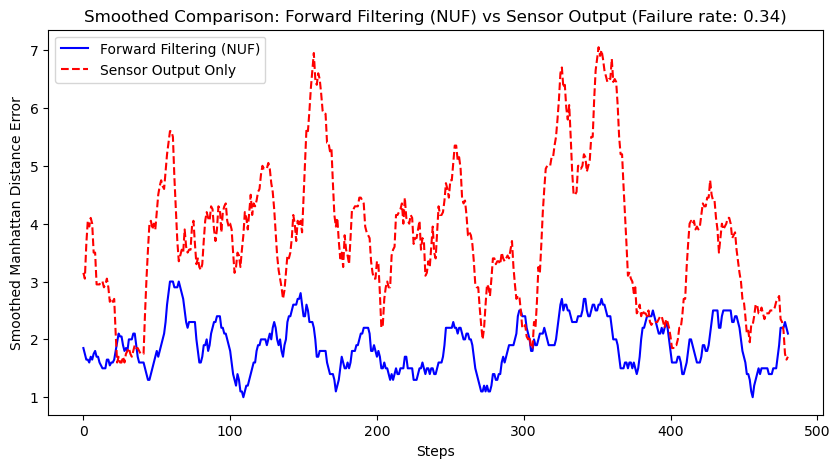

Average error (NUF Filtering): 1.91
Average error (Sensor Output Only): 3.72
Sensor failure rate: 0.34


In [5]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# اضافه کردن مسیر پروژه به `sys.path`
sys.path.append(os.path.abspath("."))

from models import StateModel, TransitionModel, RobotSim
from models.ObservationModel_NUF import ObservationModel
from Filters import HMMFilter

def run_experiment_nuf_vs_sensor(grid_size, steps):
    state_model = StateModel(*grid_size)
    transition_model = TransitionModel(state_model)
    observation_model = ObservationModel(state_model)

    true_state = np.random.randint(state_model.get_num_of_states())
    hmm_filter = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model, state_model)
    robot_sim = RobotSim(true_state, state_model)
    
    true_positions = []
    estimated_positions_filter = []
    estimated_positions_sensor = []
    errors_filter = []
    errors_sensor = []
    sensor_failures = 0  # شمارش خرابی سنسور

    for _ in range(steps):
        true_state = robot_sim.move_once(transition_model)
        sensor_reading = robot_sim.sense_in_current_state(observation_model)
        
        # اگر سنسور نتواسته بود چیزی تشخیص دهد (خطای سنسور)
        if sensor_reading is None:
            sensor_failures += 1
        
        filtered_prob = hmm_filter.filter(sensor_reading)
        
        true_pos = state_model.state_to_position(true_state)
        estimated_filter = state_model.state_to_position(np.argmax(filtered_prob))
        estimated_sensor = state_model.reading_to_position(sensor_reading) if sensor_reading is not None else (0, 0)

        true_positions.append(true_pos)
        estimated_positions_filter.append(estimated_filter)
        estimated_positions_sensor.append(estimated_sensor)

        errors_filter.append(abs(true_pos[0] - estimated_filter[0]) + abs(true_pos[1] - estimated_filter[1]))
        errors_sensor.append(abs(true_pos[0] - estimated_sensor[0]) + abs(true_pos[1] - estimated_sensor[1]))

    # محاسبه فرکانس متوسط خرابی‌های سنسور
    failure_rate = sensor_failures / steps

    return np.array(errors_filter), np.array(errors_sensor), failure_rate

# مقایسه برای شبکه 8x8
grid_size = (8, 8)  
steps = 500  
errors_filter, errors_sensor, failure_rate = run_experiment_nuf_vs_sensor(grid_size, steps)

# رسم نمودار خطاهای اصلی
plt.figure(figsize=(10, 5))
plt.plot(np.arange(steps), errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(steps), errors_sensor, label="Sensor Output Only", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Manhattan Distance Error")
plt.title(f"Comparison: Forward Filtering (NUF) vs Sensor Output (Failure rate: {failure_rate:.2f})")
plt.legend()
plt.show()

# محاسبه میانگین متحرک برای صاف کردن نمودارها
window_size = 20  # تعداد نقاط برای میانگین‌گیری
smoothed_errors_filter = np.convolve(errors_filter, np.ones(window_size)/window_size, mode='valid')
smoothed_errors_sensor = np.convolve(errors_sensor, np.ones(window_size)/window_size, mode='valid')

# رسم نمودارهای صاف شده
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(smoothed_errors_filter)), smoothed_errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(len(smoothed_errors_sensor)), smoothed_errors_sensor, label="Sensor Output Only", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Smoothed Manhattan Distance Error")
plt.title(f"Smoothed Comparison: Forward Filtering (NUF) vs Sensor Output (Failure rate: {failure_rate:.2f})")
plt.legend()
plt.show()

# چاپ میانگین خطاها
print(f"Average error (NUF Filtering): {np.mean(errors_filter):.2f}")
print(f"Average error (Sensor Output Only): {np.mean(errors_sensor):.2f}")
print(f"Sensor failure rate: {failure_rate:.2f}")


D:\2025-Semester-2\Artificial-Intelligence\Assignment-2\4\handout2025\Filters.py:67: RuntimeWarning: invalid value encountered in divide
  smoothed_probs[t] /= np.sum(smoothed_probs[t])  # Normalize


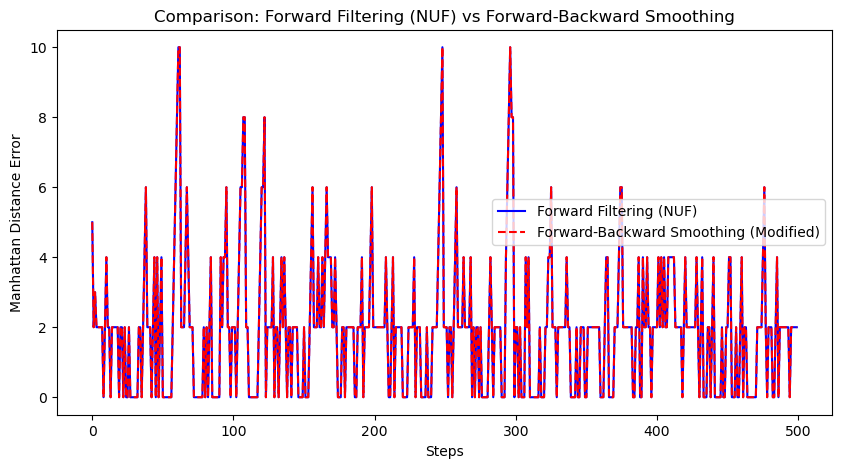

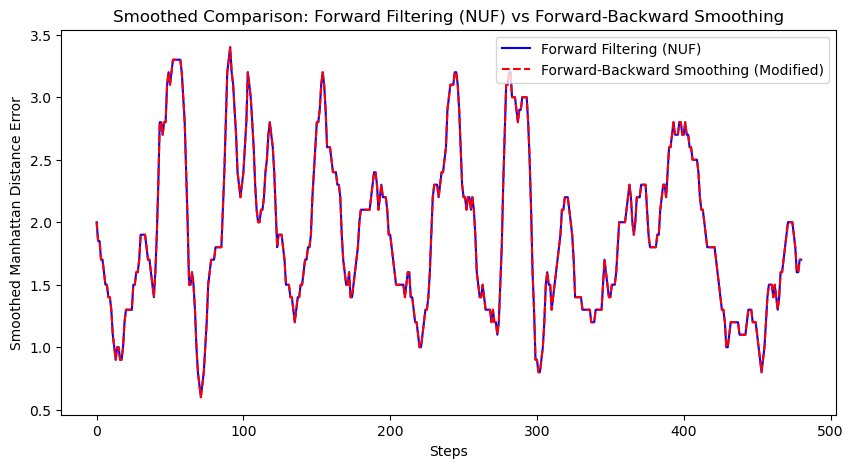

Average error (NUF Filtering): 1.92
Average error (Forward-Backward Smoothing): 1.92


In [7]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# اضافه کردن مسیر پروژه به `sys.path`
sys.path.append(os.path.abspath("."))

from models import StateModel, TransitionModel, RobotSim
from models.ObservationModel_NUF import ObservationModel
from Filters import HMMFilter, HMMSmoother


import numpy as np
import matplotlib.pyplot as plt
from models import *

def run_experiment_forward_filtering_vs_smoothing(grid_size, steps):
    state_model = StateModel(*grid_size)
    transition_model = TransitionModel(state_model)
    observation_model = ObservationModel(state_model)

    true_state = np.random.randint(state_model.get_num_of_states())
    hmm_filter = HMMFilter(np.ones(state_model.get_num_of_states()) / state_model.get_num_of_states(), transition_model, observation_model, state_model)
    forward_backward_smoothing = HMMSmoother(transition_model, observation_model, state_model)  # For smoothing
    robot_sim = RobotSim(true_state, state_model)
    
    true_positions = []
    estimated_positions_filter = []
    estimated_positions_smooth = []
    errors_filter = []
    errors_smooth = []

    for _ in range(steps):
        true_state = robot_sim.move_once(transition_model)
        sensor_reading = robot_sim.sense_in_current_state(observation_model)
        filtered_prob = hmm_filter.filter(sensor_reading)
        smoothed_prob = forward_backward_smoothing.smooth([sensor_reading] * steps, np.array([filtered_prob] * steps))  # Simplified smoothing example
        
        true_pos = state_model.state_to_position(true_state)
        estimated_filter = state_model.state_to_position(np.argmax(filtered_prob))
        estimated_smooth = state_model.state_to_position(np.argmax(smoothed_prob[-1]))  # Last smoothed estimate

        true_positions.append(true_pos)
        estimated_positions_filter.append(estimated_filter)
        estimated_positions_smooth.append(estimated_smooth)

        errors_filter.append(abs(true_pos[0] - estimated_filter[0]) + abs(true_pos[1] - estimated_filter[1]))
        errors_smooth.append(abs(true_pos[0] - estimated_smooth[0]) + abs(true_pos[1] - estimated_smooth[1]))

    return np.array(errors_filter), np.array(errors_smooth)

grid_size = (10, 10)  # 10x10 grid
steps = 500
errors_filter, errors_smooth = run_experiment_forward_filtering_vs_smoothing(grid_size, steps)

# Plotting the comparison
plt.figure(figsize=(10, 5))
plt.plot(np.arange(steps), errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(steps), errors_smooth, label="Forward-Backward Smoothing (Modified)", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Manhattan Distance Error")
plt.title("Comparison: Forward Filtering (NUF) vs Forward-Backward Smoothing")
plt.legend()
plt.show()

# Plotting smoothed comparison
window_size = 20
smoothed_errors_filter = np.convolve(errors_filter, np.ones(window_size)/window_size, mode='valid')
smoothed_errors_smooth = np.convolve(errors_smooth, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(smoothed_errors_filter)), smoothed_errors_filter, label="Forward Filtering (NUF)", color="blue")
plt.plot(np.arange(len(smoothed_errors_smooth)), smoothed_errors_smooth, label="Forward-Backward Smoothing (Modified)", color="red", linestyle="dashed")
plt.xlabel("Steps")
plt.ylabel("Smoothed Manhattan Distance Error")
plt.title("Smoothed Comparison: Forward Filtering (NUF) vs Forward-Backward Smoothing")
plt.legend()
plt.show()

print(f"Average error (NUF Filtering): {np.mean(errors_filter):.2f}")
print(f"Average error (Forward-Backward Smoothing): {np.mean(errors_smooth):.2f}")

